---
title: "Running a Phylogenetic OU Regression with R and Stan"
author: "Gerhard Jäger"#
date: "June 12, 2025"
format: html
jupyter: ir
---


# Running a Phylogenetic OU Regression with R and Stan

In this notebook, I will illustrate how one can set up a logistic regression with a phylogenetic random effect following an Ornstein-Uhlenbeck process using R and Stan. 

This kind of analysis has conceptual advantages compared with alternatives - such as phylogenetic random effects following a Brownian motion, or correlated evolution using discrete characters and the CTMC model. However, while there are off-the-shelf solutions for the latter two, the OU regression is, to my knowledge, not yet implemented in a dedicated function or package. Such a model can be set up quite easily in Stan, however. This notebook serves to illustrate how this can be done.


## Loading the required packages

In [1]:
library(tidyverse)
library(rstan)
library(parallel)
rstan_options(auto_write = TRUE)
library(ape)
library(R.utils)
library(bridgesampling)
library(loo)
library(bayesplot)
library(codetools)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: StanHeaders


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading u

## Data

Now let's get some data. I will use the EDGE tree (Bouckaert 2022).

In [2]:
# Create data directory if it doesn't exist
if (!dir.exists("../data")) dir.create("../data", recursive = TRUE)

# Download the file if it doesn't exist
tree_gz <- "../data/global-language-tree-MCC-labelled.tree.gz"
tree_file <- "../data/global-language-tree-MCC-labelled.tree"
if (!file.exists(tree_file)) {
    download.file(
        url = "https://github.com/rbouckaert/global-language-tree-pipeline/releases/download/v1.0.0/global-language-tree-MCC-labelled.tree.gz",
        destfile = tree_gz,
        mode = "wb"
    )
    R.utils::gunzip(tree_gz, destname = tree_file, overwrite = TRUE)
    # Remove the gzipped file after extraction
    if (file.exists(tree_gz)) file.remove(tree_gz)
}

edge_tree <- read.nexus(tree_file)

edge_tree$tip.label <- sapply(strsplit(edge_tree$tip.label, "_"), `[`, 1)


## Grambank data

I will look at the somewhat boring feature pair:
- GB193: What is the order of adnominal property word and noun?
- GB133: Is a pragmatically unmarked constituent order verb-final for transitive clauses?



First we get the grambank data.

In [3]:
grambank_file = "../data/grambank_vals.csv"
if (!file.exists(grambank_file)) {
    values_url <- "https://raw.githubusercontent.com/grambank/grambank/refs/heads/master/cldf/values.csv"
    vals <- read_csv(values_url, na = "")
    write(vals, grambank_file)
} else {
    vals <- read_csv(grambank_file)
}

Rows: 441663 Columns: 9
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (9): ID, Language_ID, Parameter_ID, Value, Code_ID, Comment, Source, Sou...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Now we filter out the datapoints for the two parameters of interest and the languages in the tree. I only consider two values per parameter, and only languages having a relevant value for both parameters.

In [4]:
d <- vals %>%
    filter(Language_ID %in% edge_tree$tip.label) %>%
    filter(Parameter_ID %in% c("GB193", "GB133")) %>%
    select(Language_ID, Parameter_ID, Value) %>%
    filter(Value %in% c(0, 1, 2)) %>%
    mutate(Value = as.numeric(Value)) %>%
    pivot_wider(names_from = Parameter_ID, values_from = Value) %>%
    filter(GB193 > 0) %>%
    drop_na()

Now we prune the tree to only include the languages in the data.

In [5]:
pruned_tree <- drop.tip(edge_tree, setdiff(edge_tree$tip.label, d$Language_ID))

# Check that d$Language_ID and pruned_tree$tip.label are the same set
if (!setequal(d$Language_ID, pruned_tree$tip.label)) {
    warning("Mismatch between d$Language_ID and pruned_tree$tip.label")
    print(setdiff(d$Language_ID, pruned_tree$tip.label))
    print(setdiff(pruned_tree$tip.label, d$Language_ID))
} else {
    message("d$Language_ID and pruned_tree$tip.label match.")
}

d$Language_ID and pruned_tree$tip.label match.



Now the rows in `d` are rearranged to match the order of the tips in the pruned tree.

In [6]:
d <- d[match(pruned_tree$tip.label, d$Language_ID), ]

Finally we convert the features to numeric values, and convert to 0/1

In [7]:
d <- d %>%
    mutate(x = GB193 - 1,
           y = GB133 
    )

Let's have a look at the tree and the data.

Language_ID,GB133,GB193,x,y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
abad1241,1,2,1,1
abar1238,0,2,1,0
abee1242,0,2,1,0
abua1245,0,2,1,0
abun1252,0,2,1,0
acha1249,1,2,1,1
acha1250,0,2,1,0
ache1245,0,2,1,0
ache1246,1,2,1,1


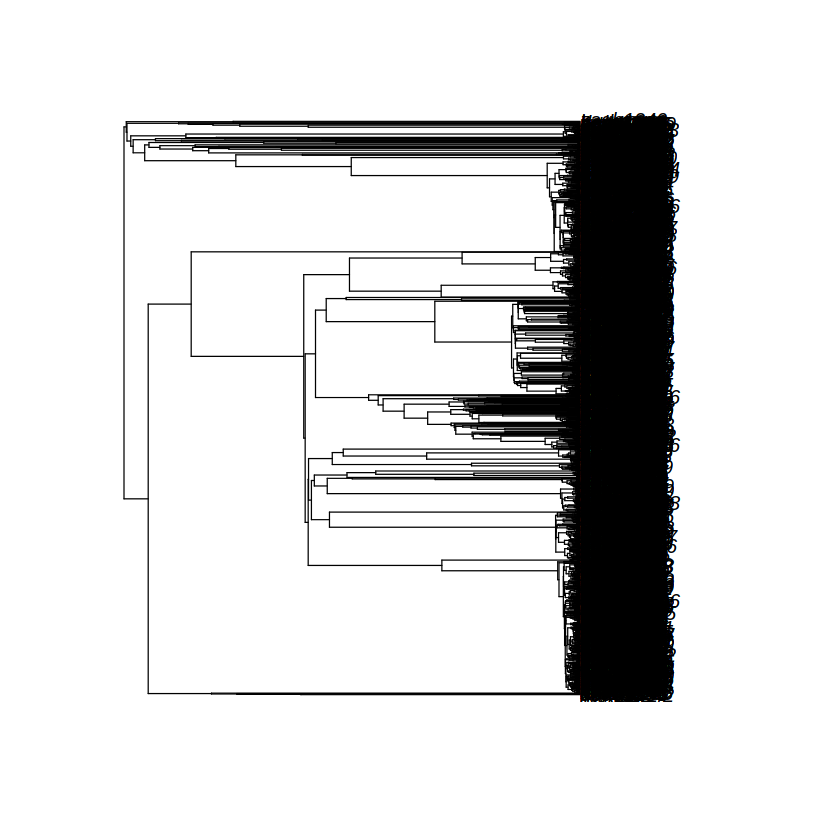

In [8]:
plot(pruned_tree)

d %>% head(10)

## Stan model

The tree is represented as a phylo object in `ape`, which is suitable for Stan.

Just to be on the safe side, we make sure that the branches are in postorder.

In [9]:
pruned_tree <- reorder(pruned_tree, "postorder")

Now we code the tree and the data as a data list.

In [10]:
stan_data = list(
    N = nrow(d),  # Number of languages
    x = d$x,  # Predictor variable (numeral-noun order)
    y = d$y,  # Response variable (adnominal demonstrative-noun order)
    edge = pruned_tree$edge,  # Edges of the tree
    edge_length = pruned_tree$edge.length  # Lengths of the edges
)

### Vanilla logistic regression

We start with a simple logistic regression without any phylogenetic effects, just to see how it works.

The model formula is:

$$
\begin{align}
\alpha &\sim \mathcal N(0, 10)\\
\beta &\sim \mathcal N(0, 10)\\
y &\sim \text{Bernoulli}(\text{logit}^{-1}(\alpha + \beta x))
\end{align}
$$

Let's run this in Stan.


In [11]:
stan_code_vanilla <- "
data {
    int<lower=0> N;                      // Number of observations
    vector[N] x;                         // Predictor variable
    array[N] int<lower=0,upper=1> y;     // Response variable (binary)
}
parameters {
    real alpha;      // Intercept
    real beta;       // Slope
}
model {
    // Priors
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);

    // Likelihood
    y ~ bernoulli_logit(alpha + beta * x);
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N) {
        log_lik[n] = bernoulli_logit_lpmf(y[n] | alpha + beta * x[n]);
    }
}
"
stan_model_vanilla <- stan_model(model_code = stan_code_vanilla)
fit_vanilla <- sampling(stan_model_vanilla, data = stan_data, iter = 2000, chains = 4)
print(fit_vanilla, pars = c("alpha", "beta"))


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.373 seconds (Warm-up)
Chain 1:                0.353 seconds (Sampling)
Chain 1:                0.72

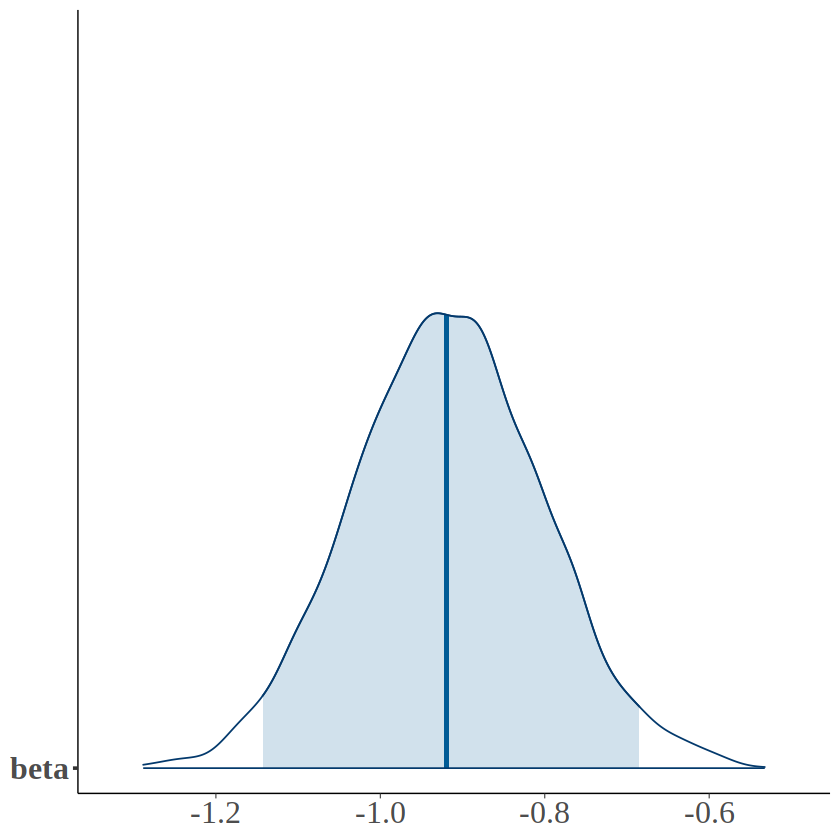

In [12]:
mcmc_areas(
    as.matrix(fit_vanilla),
    pars="beta",
    prob = 0.95
) + ggplot2::theme(text = ggplot2::element_text(size = 24))

The posterior distribution of the slope $\beta$ does not include zero, indicating that there is a significant relationship between the predictor variable `x` and the response variable `y`. The direction is negative, meaning that N-ANM order disfavors OV order.


For model comparison, we can use the `bridgesampling` package to compute the log marginal likelihood.

In [13]:
log_marginal_likelihood_vanilla_regression <- bridge_sampler(fit_vanilla)
print(log_marginal_likelihood_vanilla_regression)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Bridge sampling estimate of the log marginal likelihood: -1007.176
Estimate obtained in 4 iteration(s) via method "normal".


### Vanilla logistic correlation study

A regression model assumes an asymmetry between the predictor variable (which is not modeled) and the response variabel (which is modeled). This is not really justified in observational studies where we have not control over the predictor variable. A more appropriate model is one where both variables are generated by some stochastic process. 

This can be modeled as follows:

$$	
\begin{align}
z &\sim \mathcal N(\mu, R)\\
R &\sim \text{LKJ}(1)\\
\mu &= \mathcal N(\mathbf 0, 2\mathbf I)\\
x &\sim \text{Bernoulli}(\text{logit}^{-1}(z_1))\\
y &\sim \text{Bernoulli}(\text{logit}^{-1}(z_2))
\end{align}
$$

Here $z$ is a bivariate normal variable with mean $\mu$ and covariance $R$. The two components of $z$ have standard deviations 1, and the correlation between them is given by $\rho = R_{12} = R_{21}$. The correlation matrix is generated from a uniform distribution distribution, which is a flexible way to model correlations. The two variables $x$ and $y$ are then generated from the first and second components of $z$, respectively, using the logistic function. 

The interesting question is then whether the correlation between $x$ and $y$, i.e., $\rho = r_{21}$, is significantly different from zero. If it is, this indicates that there is a significant correlation between the two variables, which is what we are interested in.

In [14]:
stan_code_vanilla_corr <- "
data {
  int<lower=0> N;
  array[N] int<lower=0, upper=1> x;
  array[N] int<lower=0, upper=1> y;
}

parameters {
  vector[2] mu;                          // Mean of latent variables
  cholesky_factor_corr[2] L_R;           // Cholesky factor of correlation matrix
  matrix[2, N] z_raw;                    // Standard normal latent variables
}

transformed parameters {
  real rho = L_R[2, 1];
  matrix[2, N] z;
  z = rep_matrix(mu, N) + L_R * z_raw;
}

model {
  // Priors
  mu ~ normal(0, 5);
  L_R ~ lkj_corr_cholesky(2);
  to_vector(z_raw) ~ normal(0, 1); // standard normal prior for latent

  // Likelihood
  for (n in 1:N) {
    x[n] ~ bernoulli_logit(z[1, n]);
    y[n] ~ bernoulli_logit(z[2, n]);
  }
}

generated quantities {
  vector[N] log_lik_x;
  vector[N] log_lik_y;

  for (n in 1:N) {
    log_lik_x[n] = bernoulli_logit_lpmf(x[n] | z[1, n]);
    log_lik_y[n] = bernoulli_logit_lpmf(y[n] | z[2, n]);
  }
}
"
stan_model_vanilla_corr <- stan_model(model_code = stan_code_vanilla_corr)

In [15]:
fit_vanilla_corr <- sampling(
    stan_model_vanilla_corr,
    data = stan_data,
    iter = 10000,
    chains = 4, 
    control = list(adapt_delta = 0.95, max_treedepth = 15)
)
print(fit_vanilla_corr, pars = c("mu", "rho"))


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000385 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.85 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 64.201 seconds (Warm-up)
Chain 1:                50.131 seconds (Sampling)
Chain 1:    

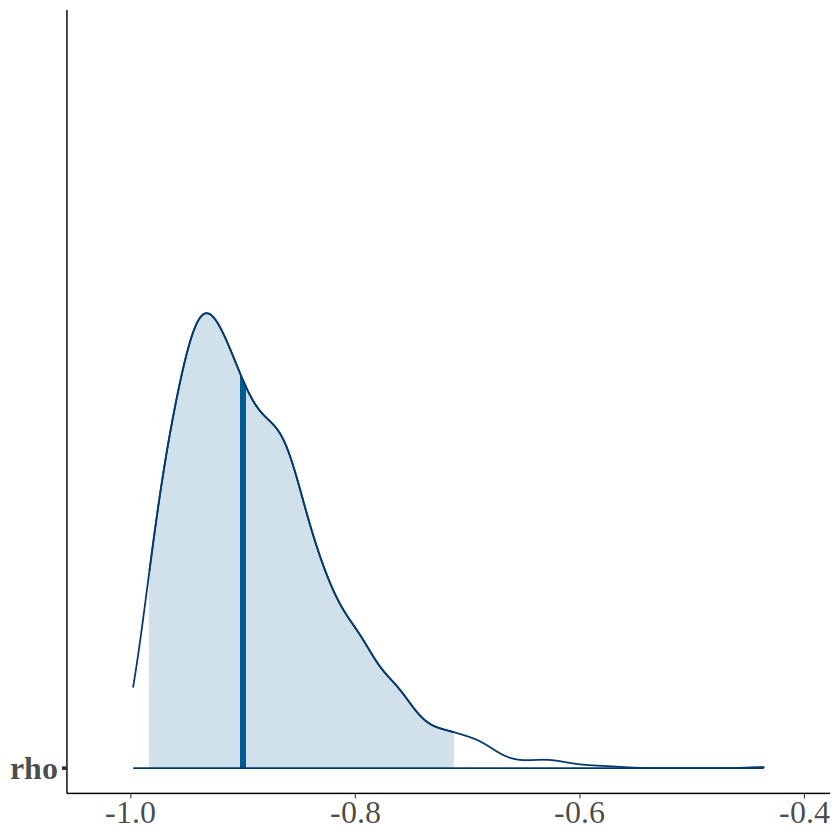

In [16]:
# Apply thinning to show just 10% of the data
posterior_samples <- as.matrix(fit_vanilla_corr)
n <- nrow(posterior_samples)
thin_idx <- seq(1, n, by = ceiling(n / (n * 0.1)))
mcmc_areas(
    posterior_samples[thin_idx, ],
    pars = "rho",
    prob = 0.95
) + ggplot2::theme(text = ggplot2::element_text(size = 24))

The posterior of $\rho$ is clearly negative, with the HPD interval excluding 0. 


We compute the log marginal likelihood for this model for later use.


In [ ]:
log_marginal_likelihood_vanilla_corr <- bridge_sampler(fit_vanilla_corr)
print(log_marginal_likelihood_vanilla_corr)

A direct model comparison via Bayes Factor is not possible because the regression model models the distribution of `x` given `y`, while the correlation models the joint distribution. However, we can apply Pareto-smoothed leave one out cross-validation if we marginalize over `x` in the correlation model.

In [ ]:
# extract log-likelihood matrix: draws x observations
log_lik1 <- extract_log_lik(fit_vanilla, parameter_name = "log_lik")
log_lik2 <- extract_log_lik(fit_vanilla_corr, parameter_name = "log_lik_y")

# compute LOO
loo1 <- loo(log_lik1)
loo2 <- loo(log_lik2)

# compare
compare(loo1, loo2)

### The Ornstein-Uhlenbeck process


The OU process is a stochastic process, similar to Brownian motion. The crucial difference is that OU is ``random walk on a leash``. Technically, it is the mixture of a stochastic Brownian motion process and a deterministic trajectory exponentially converging to a mean value. It is characterized by the following distribution:
$$
X_t \sim \mathcal N(x_0e^{-\lambda t} + \mu (1-e^{-\lambda t}), \frac{\sigma^2}{2\lambda}(1-e^{-2\lambda t}))
$$

The parameters are:

- $x_0$: the initial value of the process
- $\mu$: the mean value to which the process converges
- $\lambda$: the rate of convergence to the mean value
- $\sigma$: the volatility of the process
- $t$: the time at which the process is evaluated